In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from itertools import chain

%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [3]:
## Loading NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Loading 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5285,00028477_000.png,No Finding,0,28477,058Y,F,PA,2021,2021,0.194311,0.194311
1674,00008724_000.png,No Finding,0,8724,077Y,M,PA,2500,2048,0.168000,0.168000
1770,00009358_004.png,No Finding,4,9358,062Y,F,PA,2466,2991,0.143000,0.143000


In [4]:
# Defining set of labels
findings_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')).tolist())))
findings_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [5]:
len(findings_labels)

15

In [6]:
# Splitting the "Finding Labels" columns to have a binary column for each finding
for label in findings_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].apply(lambda x: 1.0 if label in x else 0)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Checking the DataFrame for the presence of NaN values
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  Atelectasis                  112120 non-null  float64
 13 

In [8]:
## EDA

In [9]:
# Number of pneumonia cases in the dataset
scans_all = len(all_xray_df)
scans_pos = len(all_xray_df[all_xray_df.Pneumonia==1])
print(f'There are {scans_all} chest X-ray scans in the dataset, {scans_pos} of which are labeled as pneumonia, i.e.{scans_pos/scans_all*100: .3}%.')
print(f'There are {scans_all-scans_pos} non-pneumonia cases')

There are 112120 chest X-ray scans in the dataset, 1431 of which are labeled as pneumonia, i.e. 1.28%.
There are 110689 non-pneumonia cases


- The data set is highly imbalanced

In [10]:
# Number of patient IDs in the dataset
no_of_patients_ID = len(all_xray_df['Patient ID'].unique())
print(f'There are {no_of_patients_ID} of unique patient IDs')

There are 30805 of unique patient IDs


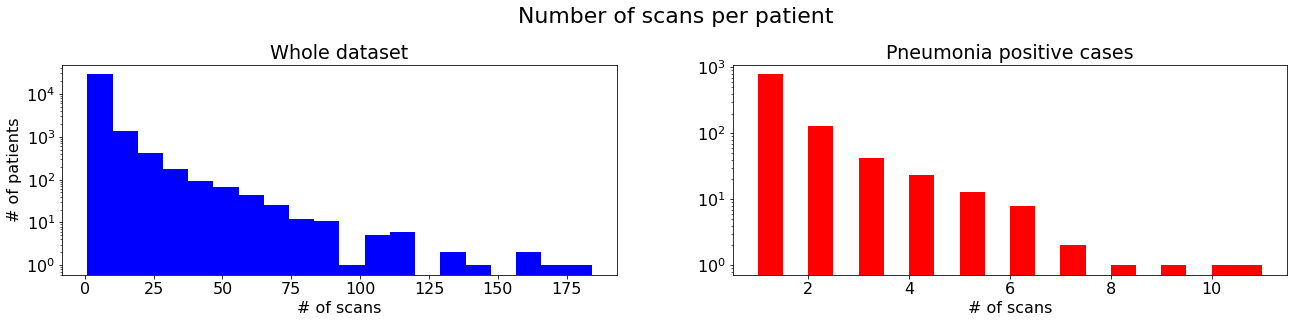

10007    184
13670    173
15530    158
12834    157
13993    143
        ... 
3301       1
5350       1
7399       1
19693      1
22485      1
Name: Patient ID, Length: 30805, dtype: int64

In [11]:
# Distribution of number of scans per patient for the whole data set and for pneumonia cases
fig, ax = plt.subplots(1,2, figsize=(20,6))
fig.suptitle("Number of scans per patient", fontsize=22, y = 0.9, x = 0.52)

ax[0].hist(all_xray_df['Patient ID'].value_counts(), bins=20, log=True, color='blue')
ax[0].set_title("Whole dataset")
ax[0].set_xlabel('# of scans')
ax[0].set_ylabel('# of patients')
ax[1].hist(all_xray_df[all_xray_df['Pneumonia'] == 1]['Patient ID'].value_counts(), bins=20, log=True, color='red')
ax[1].set_title("Pneumonia positive cases")
ax[1].set_xlabel('# of scans')
fig.tight_layout(pad=5.0)
plt.show()

all_xray_df['Patient ID'].value_counts()

- Number of scans per patient for whole dataset and pneumonia cases has similar shape of the distribution. 

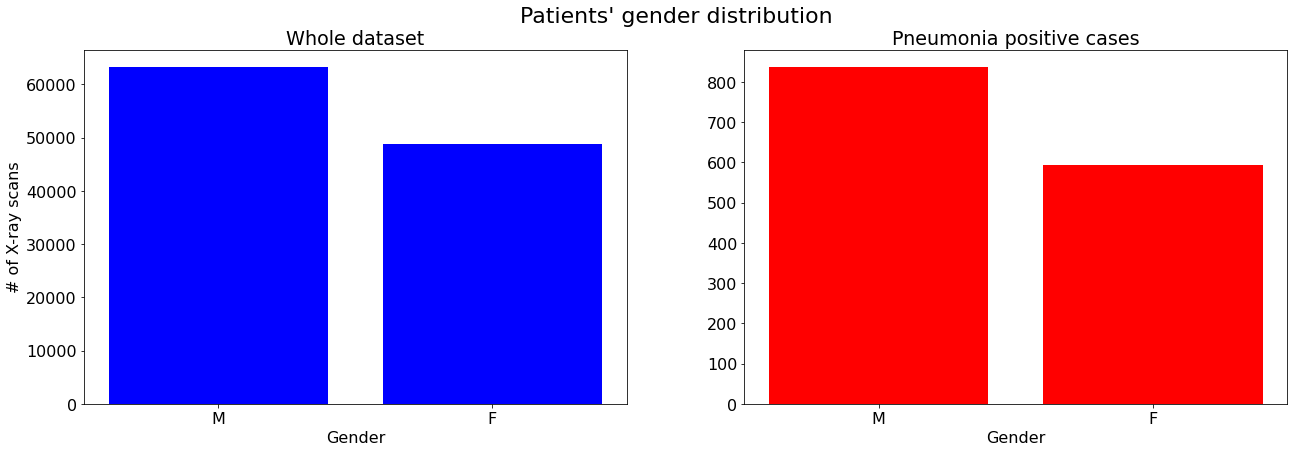

In [12]:
# Distribution of patients' gender for the whole data set and for pneumonia cases
dataset_gender = all_xray_df['Patient Gender'].value_counts()
dataset_gender_pneumonia = all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
fig.suptitle("Patients' gender distribution", fontsize=22, y = 0.9, x = 0.52)

ax[0].bar(dataset_gender.index, dataset_gender, color='blue')
ax[0].set_title("Whole dataset")
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('# of X-ray scans')

ax[1].bar(dataset_gender_pneumonia.index, dataset_gender_pneumonia, color='red')
ax[1].set_title("Pneumonia positive cases")
ax[1].set_xlabel('Gender')

fig.tight_layout(pad=5.0)
plt.show()

In [13]:
M_F_ratio_all = all_xray_df['Patient Gender'].value_counts()[0] / all_xray_df['Patient Gender'].value_counts()[1] 
print(f'M/F ratio: whole dataset {M_F_ratio_all:.2}.')

M_F_ratio_pos = all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts()[0] / all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts()[1]  
print(f'M/F ratio: pneumonia patients {M_F_ratio_pos:.2}.')

M/F ratio: whole dataset 1.3.
M/F ratio: pneumonia patients 1.4.


- The Male/Female ratio for whole dataset and pneumonia cases has similar value.

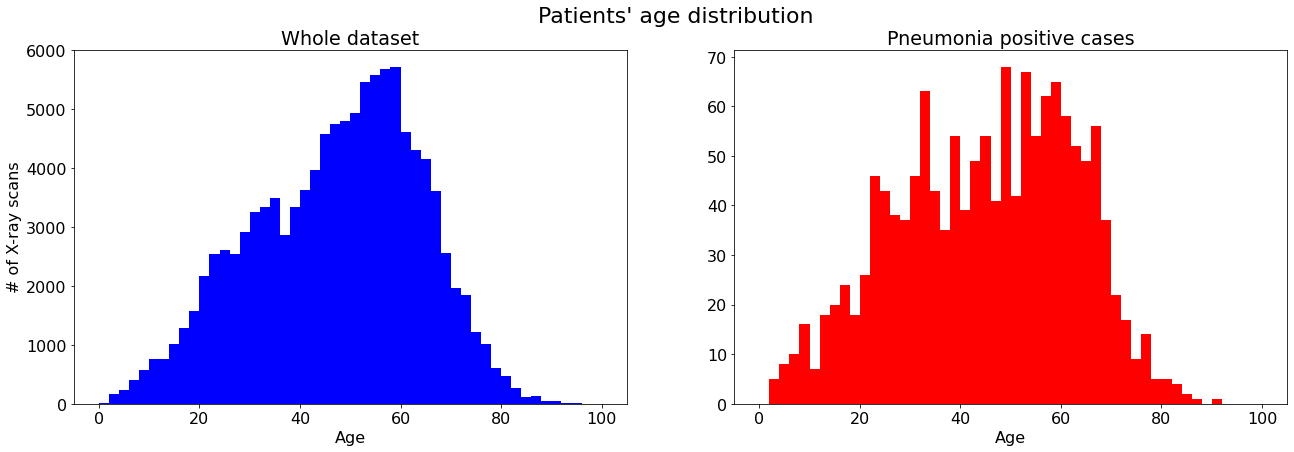

In [14]:
# Distribution of patients' age for the whole data set and for only pneumonia cases
fig, ax = plt.subplots(1,2, figsize=(20,8))
fig.suptitle("Patients' age distribution", fontsize=22, y = 0.9, x = 0.52)

ax[0].hist(all_xray_df['Patient Age'], bins=50, range=(0,100), color='blue')
ax[0].set_title("Whole dataset")
ax[0].set_xlabel('Age')
ax[0].set_ylabel('# of X-ray scans')

ax[1].hist(all_xray_df[all_xray_df['Pneumonia'] == 1]['Patient Age'], bins=50, range=(0,100), color='red')
ax[1].set_title("Pneumonia positive cases")
ax[1].set_xlabel('Age')
fig.tight_layout(pad=5.0)
plt.show()

- The patient age distribution for whole dataset has similar shape, with the pneumonia one being more noisy because of far less X-ray scans. 

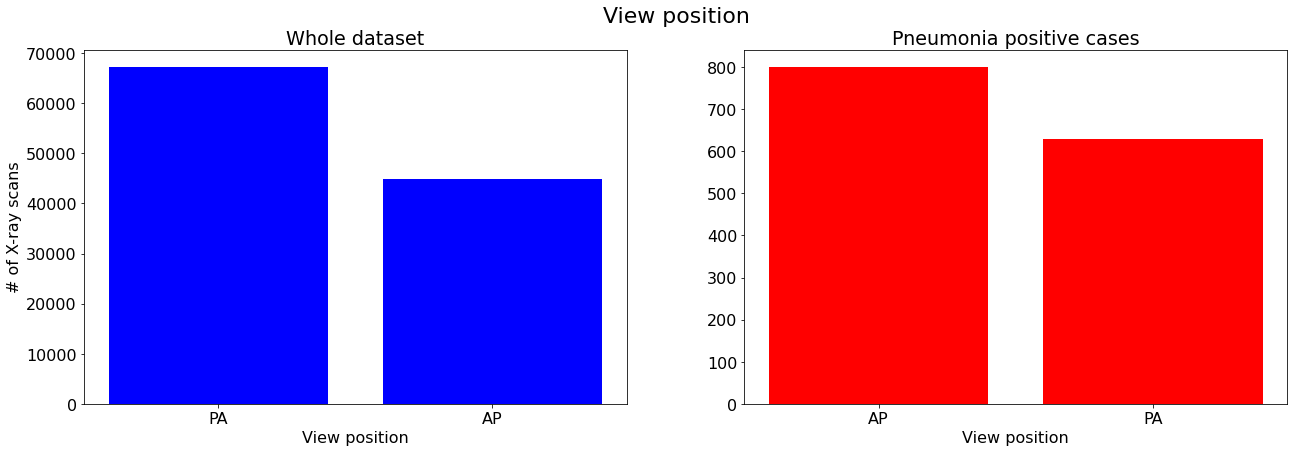

In [15]:
# Distribution of view position for the whole data set and for only pneumonia cases
dataset_view = all_xray_df['View Position'].value_counts()
dataset_view_pneumonia = all_xray_df[all_xray_df.Pneumonia == 1]['View Position'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
fig.suptitle("View position", fontsize=22, y = 0.9, x = 0.52)

ax[0].bar(dataset_view.index, dataset_view, color='blue')
ax[0].set_title("Whole dataset")
ax[0].set_xlabel('View position')
ax[0].set_ylabel('# of X-ray scans')

ax[1].bar(dataset_view_pneumonia.index, dataset_view_pneumonia, color='red')
ax[1].set_title("Pneumonia positive cases")
ax[1].set_xlabel('View position')
fig.tight_layout(pad=5.0)
plt.show()

In [16]:
PA_AP_ratio_all = all_xray_df['View Position'].value_counts()[0] / all_xray_df['View Position'].value_counts()[1] 
print(f'PA/AP ratio: whole dataset {PA_AP_ratio_all:.2}.')

PA_AP_ratio_pos = all_xray_df[all_xray_df.Pneumonia == 1]['View Position'].value_counts()[0] / all_xray_df[all_xray_df.Pneumonia == 1]['View Position'].value_counts()[1]  
print(f'PA/AP ratio: pneumonia patients {PA_AP_ratio_pos:.2}.')

PA/AP ratio: whole dataset 1.5.
PA/AP ratio: pneumonia patients 1.3.


- The PA/AP ratio for whole dataset and pneumonia cases has similar value. 

In [17]:
# Investigating the frequency findings occurance in the whole dataset
findings_freq = all_xray_df.loc[:,'Atelectasis':'Pneumothorax'].sum()/len(all_xray_df)
findings_freq

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

In [18]:
# Investigating the finding occurance in the whole dataset
findings_occurance = all_xray_df.loc[:,'Atelectasis':'Pneumothorax'].sum()
findings_occurance

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

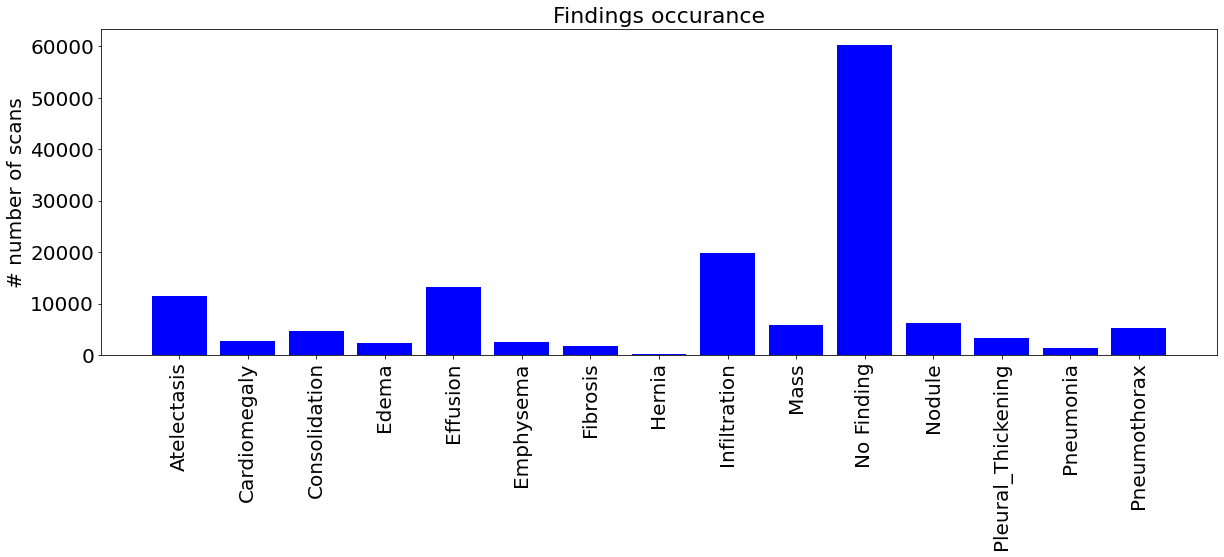

In [19]:
plt.figure(figsize=(20,6))
plt.bar(findings_labels, findings_occurance, color='blue')
plt.title('Findings occurance', fontsize=22)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('# number of scans', fontsize=20)
plt.show()

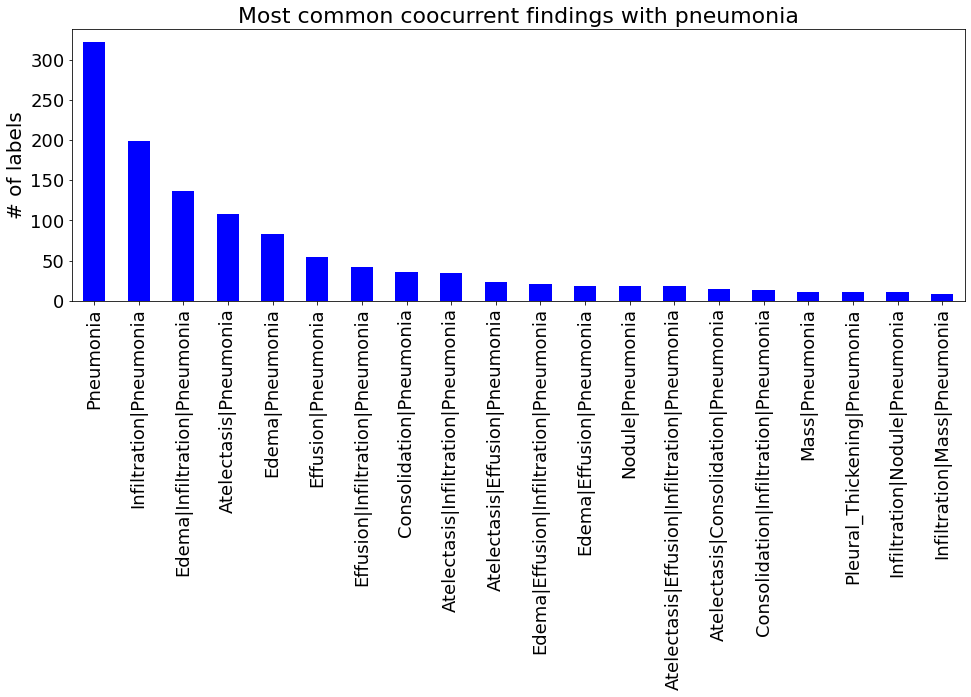

In [20]:
# Looking at common finding co-ocurrence with pneumonia
plt.figure(figsize=(16,5))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar', color='blue')
plt.title('Most common coocurrent findings with pneumonia', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('# of labels', fontsize=20)
plt.show()

In [21]:
# Number of findings per patient
findings = np.delete(findings_labels,10) # deleting "no finding" label
patient_IDs = all_xray_df['Patient ID'].value_counts() 

findings_per_patient = []
for ID in patient_IDs.index:
    findings_per_patient.append(all_xray_df[all_xray_df['Patient ID'] == ID].loc[:,findings].max(axis=0).sum())

findings_per_patient = pd.Series(findings_per_patient,  index=patient_IDs.index)
findings_per_patient

10007    11.0
13670    11.0
15530    11.0
12834    12.0
13993    10.0
         ... 
3301      0.0
5350      0.0
7399      0.0
19693     0.0
22485     2.0
Length: 30805, dtype: float64

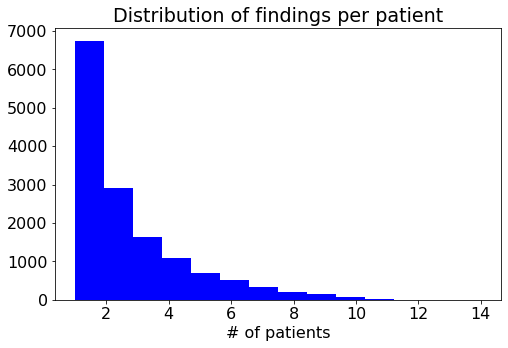

In [22]:
plt.figure(figsize=(8,5))
plt.hist(findings_per_patient, range=(1,14), bins= 14, color='blue')
plt.title('Distribution of findings per patient')
plt.xlabel('# of findings')
plt.xlabel('# of patients')
plt.show()

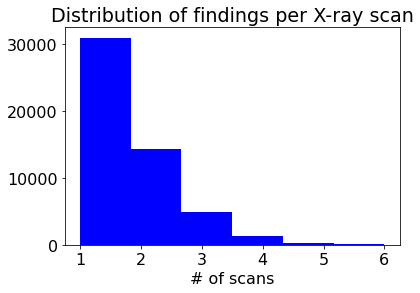

In [23]:
# Number of dieseases per X-ray scan

all_xray_df['findings_per_scan'] = all_xray_df.loc[:, findings].sum(axis=1)
plt.figure()
plt.hist(all_xray_df['findings_per_scan'], range=(1,6), bins=6, color='blue')
plt.title('Distribution of findings per X-ray scan')
plt.xlabel('# of findings')
plt.xlabel('# of scans')
plt.show()

- In one X-ray scan there can be up to 6 different findings.

In [24]:
# Sample X-ray scans
# Listing dcm files contained in directory
scan_list = sorted(glob('*.dcm'))
scan_list

['test1.dcm', 'test2.dcm', 'test3.dcm', 'test4.dcm', 'test5.dcm', 'test6.dcm']

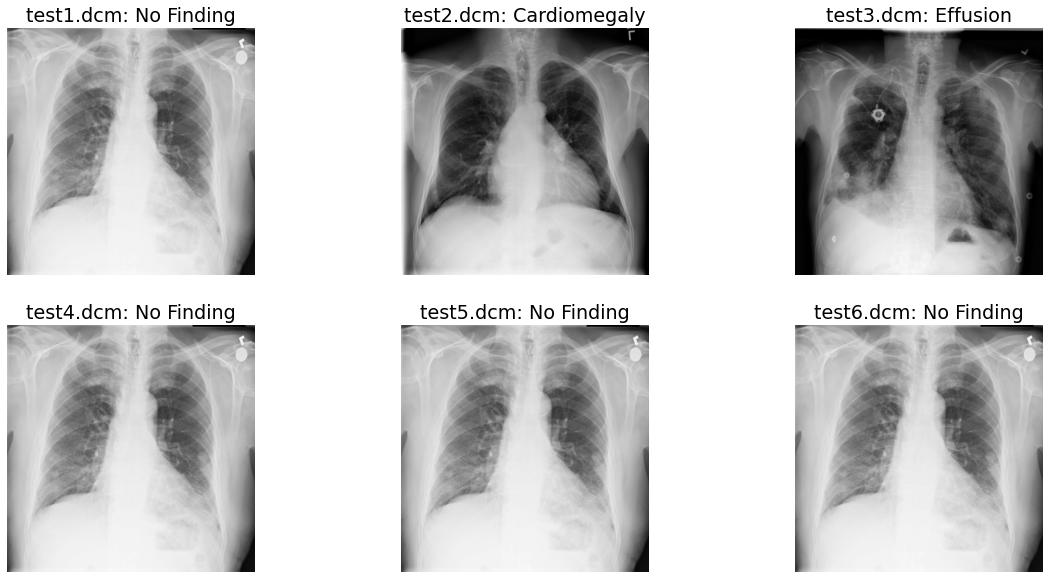

In [25]:
# Plotting the raw X-ray scans 
pixel_arrays = []
plt.figure(figsize=(20,10))
labels = []

for i, dcm_file in enumerate(scan_list):
    dicom = pydicom.dcmread(dcm_file)
    label = dicom.StudyDescription
    image = dicom.pixel_array
    plt.subplot(2,3,i+1)
    plt.imshow(image,cmap='gray')
    plt.title(dcm_file + ": " + label)
    plt.axis('off')
    
    pixel_arrays.append(image)
    labels.append(label)

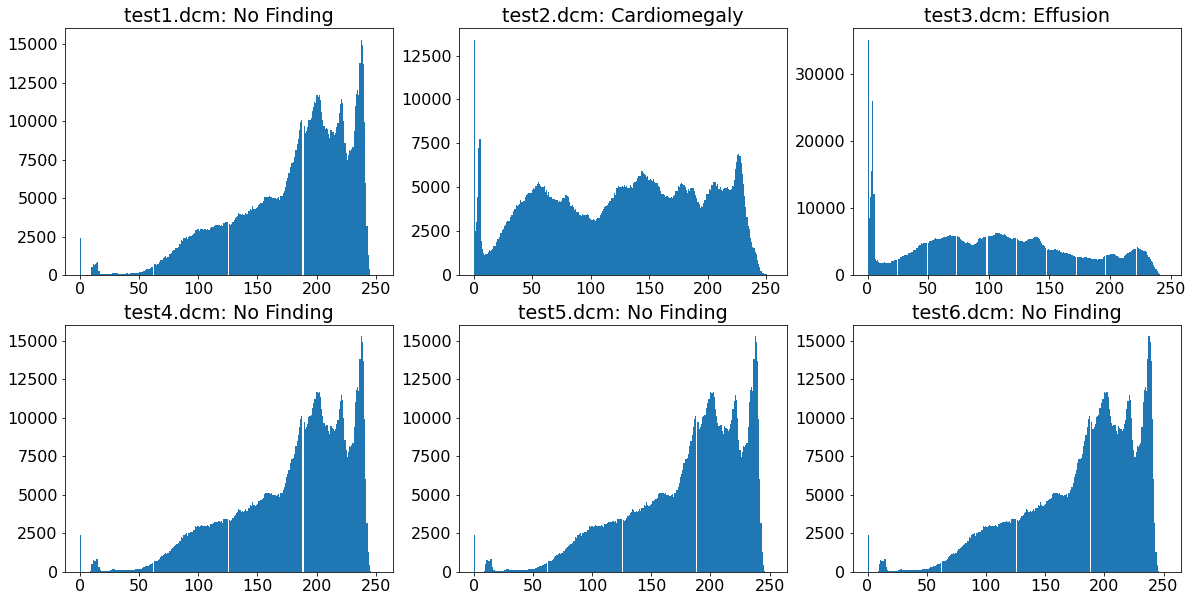

In [26]:
# Investigating the intenisty distribution of the raw X-ray scans 
plt.figure(figsize=(20,10))

for i in range(len(scan_list)):
    plt.subplot(2,3,i+1)
    plt.hist(pixel_arrays[i].ravel(), bins=256)
    plt.title(scan_list[i] + ": " + labels[i])

- The chest scans, in which cariomegaly and effusion are present, have significantly different intenisty distribution.

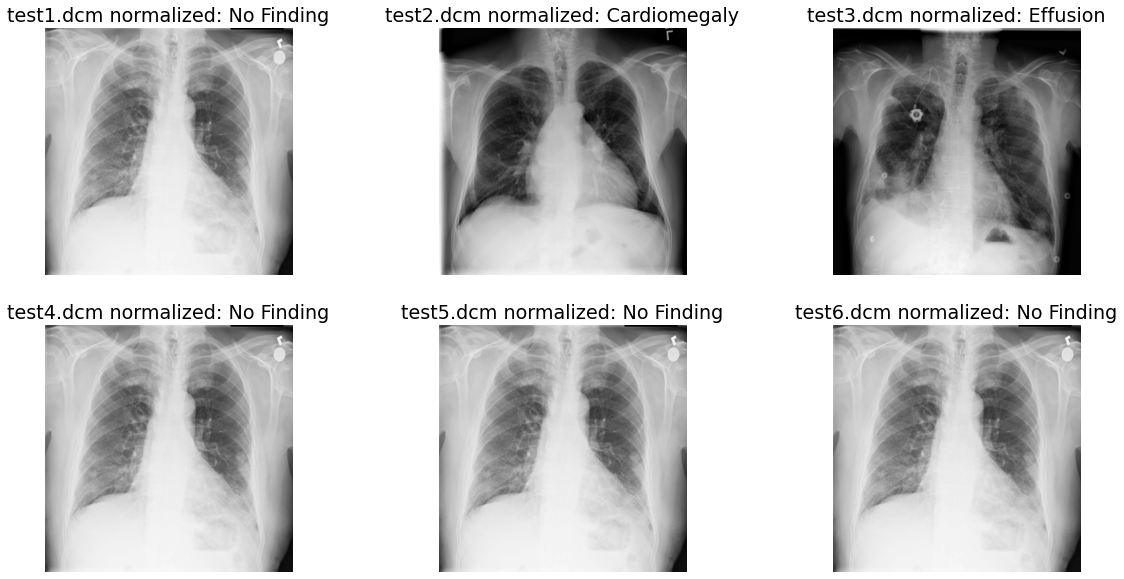

In [27]:
# Plotting of normalized scans
pixel_arrays_norm = []
plt.figure(figsize=(20,10))

for i, dcm_file in enumerate(scan_list):
    dicom = pydicom.dcmread(dcm_file)
    image = dicom.pixel_array
    image_mean = np.mean(image)
    image_std = np.std(image)
    image_norm = (image - image_mean)/image_std
    plt.subplot(2,3,i+1)
    plt.imshow(image_norm,cmap='gray')
    plt.title(dcm_file + " normalized: " + labels[i])
    plt.axis('off')
    
    pixel_arrays_norm.append(image_norm)

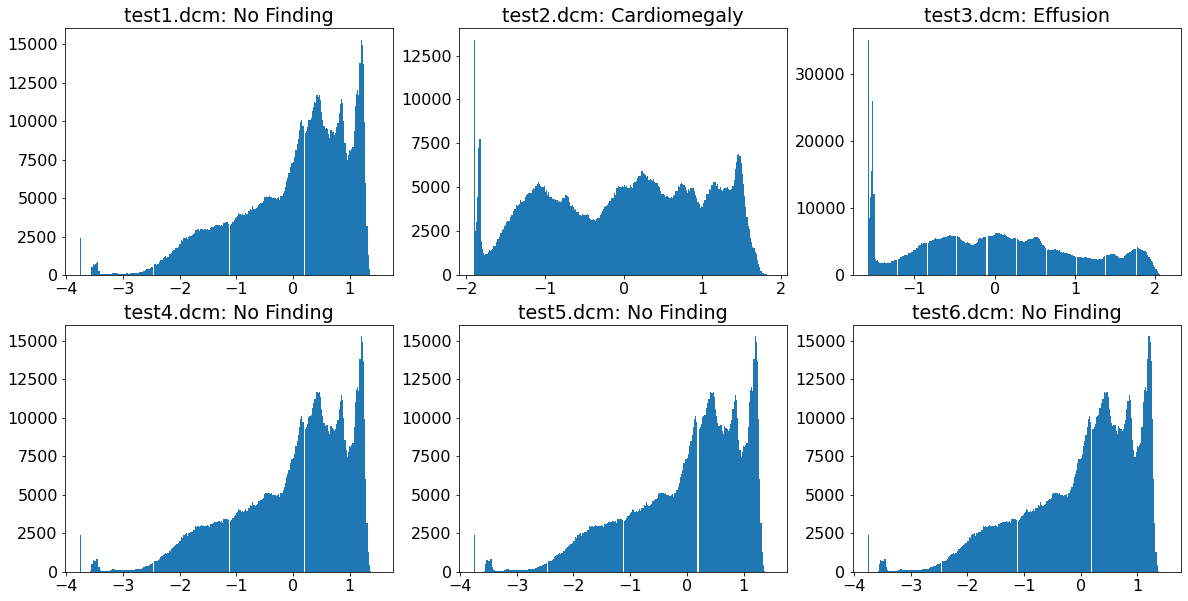

In [28]:
# Investigating the intenisty distribution of the normalized X-ray scans 
plt.figure(figsize=(20,10))

for i in range(len(scan_list)):
    plt.subplot(2,3,i+1)
    plt.rcParams.update({'font.size': 16})
    plt.hist(pixel_arrays_norm[i].ravel(), bins=256)
    plt.title(scan_list[i] + ": " + labels[i])

- The chest scans, in which cariomegaly and effusion are present, have significantly different intenisty distribution,
   also when the scans are normalized